# Online DA: 
## CESM LME prior/LIM, LME observations

In [1]:
import sys
import numpy as np
import xarray as xr
import scipy.stats as spy

import matplotlib.pyplot as plt
import cartopy.crs as ccrs

import pickle 

In [2]:
sys.path.append("../")
import Online_DA_utils as oda

In [3]:
import importlib
importlib.reload(oda)

<module 'Online_DA_utils' from '../Online_DA_utils.py'>

In [4]:
t=0

# limname = 'cesm_lme_nh'
# modname = 'cesm_lme'
# obsname = 'cesm_lme'

limname = 'cesm_lme_Amon'
modname = 'cesm_lme_Amon'
obsname = 'cesm_lme_Amon'
#obsname = 'cmip6_mpi_hist_regridlme'

### Load L: 

In [5]:
LIM = oda.load_L(limname)
LIMd = LIM['LIMd']
LIMd.keys()

Loading: /home/disk/kalman2/mkb22/SI_LIMs/sensitivity_testing/master/LIMcast_cesm_lme_Amon_ntrain_850_1650_cesm_lme_Amon_validy_1651_1850_tas50L0.1_psl50L0.1_zg50L0.1_tos50L0.1_sit50L40_sic50L40_20211202_sqrtWt.pkl


dict_keys(['vec', 'veci', 'val', 'lam_L', 'C_0', 'C_1', 'Gt', 'lam_L_adj', 'npos_eigenvalues', 'E3', 'W_all', 'standard_factor', 'E3_all', 'E_sic', 'var_dict', 'P_train', 'exp_setup', 'frac_neg_eigenvals'])

In [6]:
Projector_tas = LIMd['E3']['tas']

### Load pseudo observations at HadCRUT locations: 

In [7]:
obsdir = '/home/disk/p/mkb22/Documents/si_analysis_kb/Online_DA_monthly/observations/'
#obsfilename = 'TAS_pseudo_obs_'+obsname+'_1851_2005.pkl'
obsfilename = 'TAS_pseudo_obs_'+obsname+'_hadCRUT_locations_1851_2005.pkl'
#obsfilename = 'TAS_pseudo_obs_'+obsname+'_hadCRUT_locations_fixed_network36_1851_2005.pkl'

pseudo_obs_data = pickle.load(open(obsdir+obsfilename,"rb"))

In [199]:
had_obs_data = pickle.load(open(obsdir+obsfilename,"rb"))

# had_obs_data_full = had_obs_data['had_on_refgrid'][12:1872,:,:]
had_obs_data_full = had_obs_data['observations']
had_obs_full_2d = np.reshape(had_obs_data_full, (had_obs_data_full.shape[0]*had_obs_data_full.shape[1],
                                                had_obs_data_full.shape[2]))

In [200]:
#had_155_mask = np.zeros_like((had_obs_data_full[:,:,150]))

had_155_mask = np.where(np.isfinite(had_obs_data_full[:,:,150]),1,0)

mask_test = np.zeros_like((had_obs_data_full[:,:,150]))
mask_test[1::2,1::2] = mask_test[1::2,1::2]+1

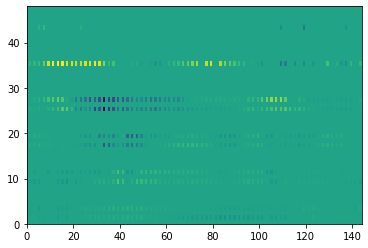

In [186]:
plt.pcolormesh(mask_test*np.nan_to_num(had_obs_data_full[:,:,1800]))

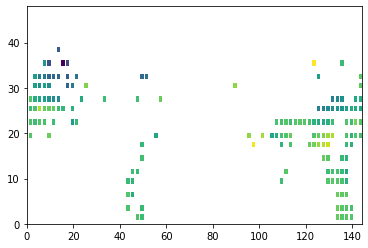

In [150]:
plt.pcolormesh(had_obs_data_full[:,:,150])

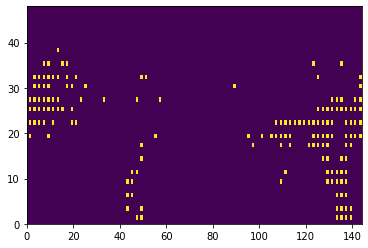

In [158]:
plt.pcolormesh(had_155_mask)

In [152]:
had_155_obs = had_155_mask[:,:,np.newaxis]*np.nan_to_num(had_obs_data_full[:,:,:])
had_155_obs[np.logical_not(np.abs(had_155_obs)>0)]=np.nan

In [153]:
nobs_155 = np.zeros((1860))

for t in range(1860):
    nobs_155[t] = np.isfinite(had_155_obs[:,:,t]).sum()

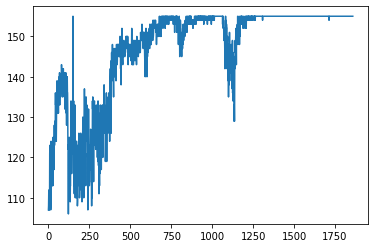

In [154]:
plt.plot(nobs_155)

In [156]:
nobs_155.min()

106.0

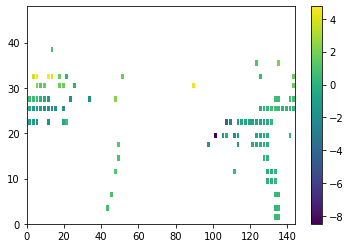

In [142]:
plt.pcolormesh(had_155_obs[:,:,0])
plt.colorbar()

In [187]:
had_obs_data_full.shape

(48, 144, 1860)

In [188]:
had_obs_data_full_2d = np.reshape(had_obs_data_full,(had_obs_data_full.shape[0]*had_obs_data_full.shape[1],had_obs_data_full.shape[2]))

In [190]:
nobs_intime = np.sum(np.isfinite(had_obs_data_full_2d), axis=1)

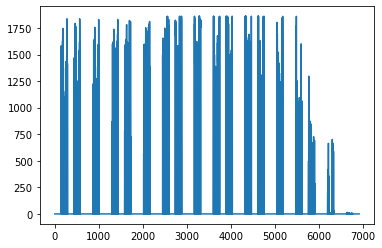

In [192]:
plt.plot(nobs_intime)

In [197]:
np.where(nobs_intime>1859)

(37,)

In [201]:
eofs_out = LIMd['E3']['tas']/LIMd['standard_factor']['tas']
P_var = np.matmul(eofs_out.T, (LIMd['W_all']['tas'][:,np.newaxis]*np.nan_to_num(had_obs_full_2d)))
Ptrunc = P_var/LIMd['standard_factor']['tas']

In [202]:
had_mask = np.zeros_like(had_obs_data_full)
had_mask[np.isfinite(had_obs_data_full)] = had_mask[np.isfinite(had_obs_data_full)]+1

In [203]:
ndof_total = 0
limvars = ['tas','psl','zg','tos','sit','sic']
for var in limvars: 
    ndof_total = ndof_total+LIMd['var_dict'][var]['var_ndof']

In [204]:
H_cap, nobs, ndof = oda.build_H_time(had_mask[:,:,0])

H = np.zeros((nobs,ndof_total))
H[:,0:6912] = H_cap

In [205]:
H.shape, H_cap.shape

((36, 35424), (36, 6912))

In [206]:
had_mask.shape

(48, 144, 1860)

In [207]:
pseudo_obs_full = pseudo_obs_data['observations']
obs_lat = pseudo_obs_data['obs_lat']
obs_lon = pseudo_obs_data['obs_lon']
obs_mask = pseudo_obs_data['H']

In [208]:
pseudo_obs_2d = np.reshape(pseudo_obs_full, (pseudo_obs_full.shape[0]*pseudo_obs_full.shape[1],
                           pseudo_obs_full.shape[2]))

In [209]:
tas_3d = pseudo_obs_data['X_var_3d'] 
tas_2d = np.reshape(tas_3d,(tas_3d.shape[0]*tas_3d.shape[1],tas_3d.shape[2]))

In [210]:
tas_2d.shape

(6912, 1860)

## Load initial conditions in eof space: 

In [211]:
priordir = '/home/disk/p/mkb22/Documents/si_analysis_kb/Online_DA_monthly/priors/'
priorname = 'Xb_initial_'+modname+'_300ndof_1651_1850.pkl'
validname = 'Xb_initial_'+modname+'_300ndof_1851_2005.pkl'

Xb_initial_data = pickle.load(open(priordir+priorname,"rb"))
Xb_initial_allt = Xb_initial_data['Xb_initial']

In [212]:
Xb_valid_data = pickle.load(open(priordir+validname,"rb"))
Xb_valid_allt = Xb_valid_data['Xb_initial']

In [213]:
ndof_total = 0
limvars = ['tas','psl','zg','tos','sit','sic']
for var in limvars: 
    ndof_total = ndof_total+LIMd['var_dict'][var]['var_ndof']

In [214]:
Pb_initial = LIMd['C_0']

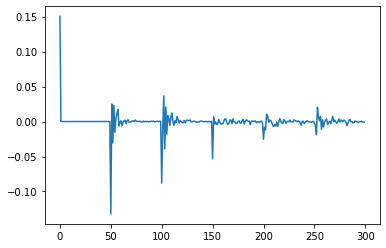

In [215]:
plt.plot(LIMd['C_0'][0,:])

In [17]:
Xb_initial_allt.shape

(300, 2400)

### Build H:
H should be a matrix of size (nobs, nlalo) filled with zeros and ones. One one per column at the ob location. 

In [216]:
H_cap, nobs, ndof = oda.build_H_time(obs_mask[:,:,0])

In [217]:
H = np.zeros((nobs,ndof_total))
H[:,0:6912] = H_cap

In [218]:
neofs = 300

In [219]:
E3_all = np.zeros((ndof_total,neofs))
ntrunc = 50

for v,var in enumerate(limvars): 
    E3_all[LIMd['var_dict'][var]['var_inds'],
           int(v*ntrunc):int((v+1)*ntrunc)] = LIMd['E3'][var]/np.sqrt(LIMd['standard_factor'][var])

In [220]:
U = E3_all

H_eof = np.matmul(H,U)

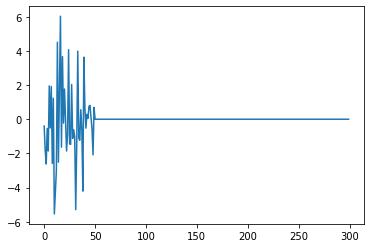

In [221]:
plt.plot(H_eof[1,:])

### Build R: 

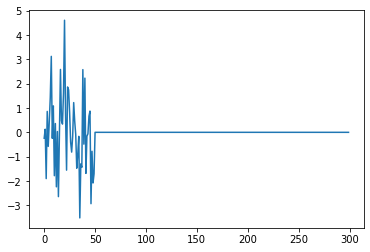

In [226]:
plt.plot(H_eof[0,:])

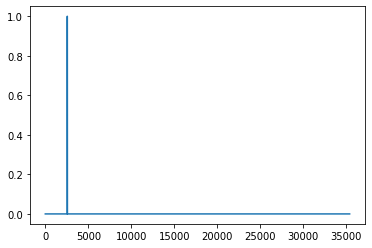

In [227]:
plt.plot(H[0,:])

In [228]:
Hx = np.matmul(H_eof,Xb_valid_allt)

In [229]:
Hx_cap = np.matmul(H_cap,tas_2d)

In [230]:
Hx.shape, Hx_cap.shape, 100*100

((36, 1860), (36, 1860), 10000)

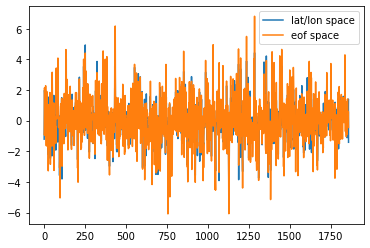

In [231]:
plt.plot(Hx_cap[0,:], label='lat/lon space')
plt.plot(Hx[0,:], label='eof space')
plt.legend()

In [232]:
epsilon = Hx_cap - Hx

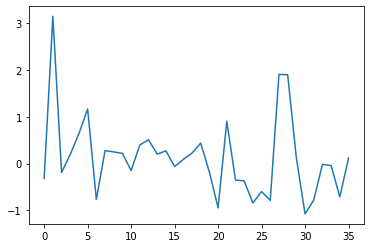

In [233]:
plt.plot(epsilon[:,0])

In [234]:
R = np.matmul(epsilon,epsilon.T)/(epsilon.shape[1]-1)

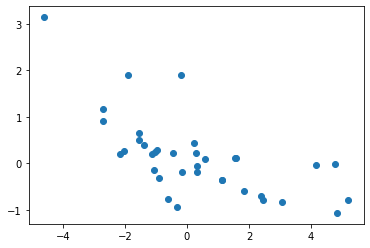

In [235]:
plt.scatter(Hx[:,0],epsilon[:,0])

In [236]:
epsilon.shape

(36, 1860)

In [237]:
slope = np.zeros(Hx.shape[0])
intercept = np.zeros(Hx.shape[0])

for i in range(Hx.shape[0]):
    slope[i], intercept[i], r, p, se = spy.linregress(Hx[i,:],epsilon[i,:])

In [238]:
slope.shape

(36,)

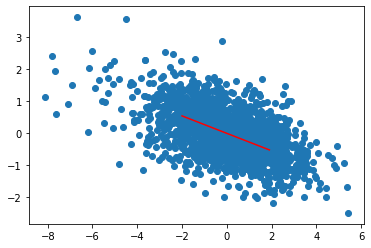

In [239]:
x = np.arange(-2,2,0.1)

plt.plot(x,slope[0]*x+intercept[0], color='r')

plt.scatter(Hx[10,:],epsilon[10,:])

In [240]:
e = epsilon - slope[:,np.newaxis]*Hx

In [241]:
e.shape

(36, 1860)

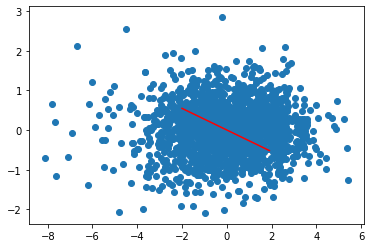

In [242]:
x = np.arange(-2,2,0.1)

plt.plot(x,slope[0]*x+intercept[0], color='r')

plt.scatter(Hx[10,:],e[10,:])

In [243]:
R_e = np.matmul(e,e.T)/(e.shape[1]-1)

In [219]:
np.trace(R_e), np.trace(R)

(388.1195070503729, 227.36849009315966)

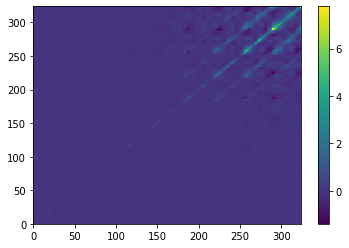

In [220]:
plt.pcolormesh(R_e)
plt.colorbar()

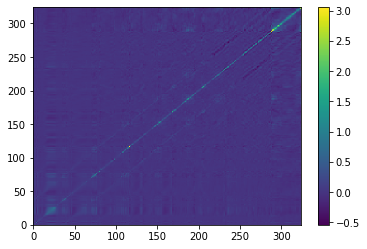

In [221]:
plt.pcolormesh(R)
plt.colorbar()

In [223]:
nyears = 155

# Generate times: 
t_total = nyears*12

In [224]:
Xa_alltime = np.zeros((t_total,neofs))
diff_alltime = np.zeros((t_total,pseudo_obs_2d.shape[0]))
K_den_alltime = np.zeros((t_total,pseudo_obs_2d.shape[0],pseudo_obs_2d.shape[0]))

MemoryError: Unable to allocate 662. GiB for an array with shape (1860, 6912, 6912) and data type float64

## Initial timestep - Kalman Filtering: 

In [222]:
t = 0

In [244]:
Xb_initial = np.nan_to_num(Xb_valid_allt[:,0])
Y = pseudo_obs_2d[:,t]

Pb = Pb_initial#*1e-3
R_hack = R_e#*1e-4
H_final = H_eof

Xa, K, K_den, diff = oda.solver_KF_update(Xb_initial, Pb, Y, R_hack, H_final)

ValueError: operands could not be broadcast together with shapes (6912,) (36,) 

In [247]:
H_final.shape, Xb_initial.shape, Y.shape

((36, 300), (300,), (6912,))

In [224]:
# plt.plot(Pb[0,:], label='Pb')
# plt.plot(R_hack[0,:], label='R')

# plt.legend(fontsize = 12)

In [225]:
R_hack.max(), R_hack.min(), 

(3.0540242122077776, -0.5406643320814724)

In [227]:
Pb.max(), Pb.min(), K_den.shape

(0.29785207823793775, -0.13204806346380715, (324, 324))

In [228]:
Pa = oda.solver_KF_cov(K,H_final,Pb*100)

In [229]:
mse_xb = np.nanmean(diff**2)
mse_xa = np.nanmean((Y - np.matmul(H_final,Xa))**2)
print('Prior MSE     = '+str(mse_xb))
print('Posterior MSE = '+str(mse_xa))

Prior MSE     = 0.9565892497670653
Posterior MSE = 0.7459078133580529


In [231]:
diffcov = np.dot(diff[:,np.newaxis],diff[:,np.newaxis].T)#/diff.shape[0]
ratio = (np.diagonal(diffcov)/np.diagonal(K_den))
print('Median Ratio = '+str(np.median(ratio)))
print('Mean Ratio = '+str(np.mean(ratio)))

Median Ratio = 0.09857919017334926
Mean Ratio = 0.2668199249880465


In [202]:
diffcov = np.dot(diff[:,np.newaxis],diff[:,np.newaxis].T)#/diff.shape[0]
ratio = (np.diagonal(diffcov)/np.diagonal(K_den))
print('Median Ratio = '+str(np.median(ratio)))
print('Mean Ratio = '+str(np.mean(ratio)))

Median Ratio = 0.048436673809124337
Mean Ratio = 0.12143765965712802


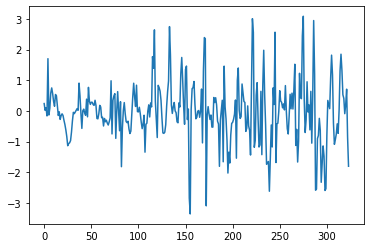

In [180]:
plt.plot(diff)

In [191]:
diff_anom = diff - diff.mean()

In [192]:
diffcov = np.dot(diff_anom[:,np.newaxis],diff_anom[:,np.newaxis].T)

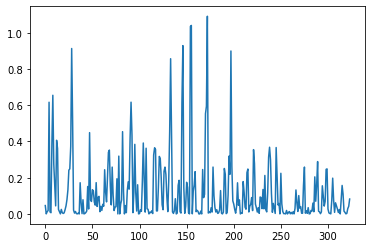

In [182]:
plt.plot(np.diagonal(diffcov)/np.diagonal(K_den))

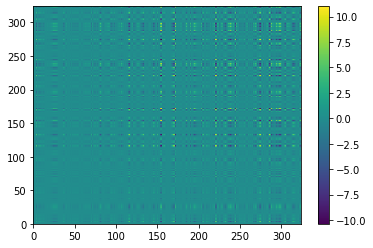

In [193]:
plt.pcolormesh(diffcov)
plt.colorbar()

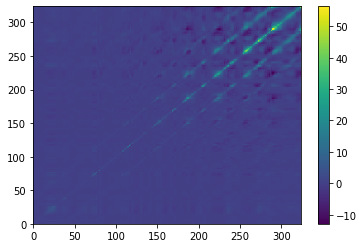

In [178]:
plt.pcolormesh(K_den)
plt.colorbar()

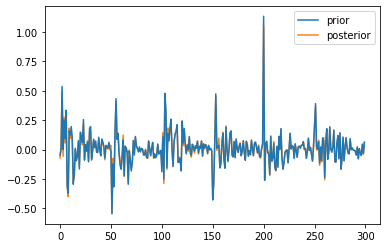

In [119]:
plt.plot(Xb_initial, label='prior',zorder=1)
plt.plot(Xa, label = 'posterior',zorder=0)
plt.legend()

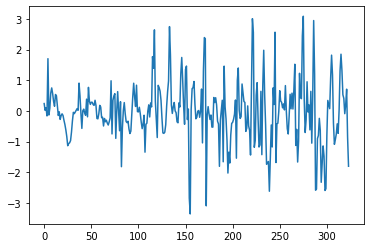

In [120]:
plt.plot(diff)

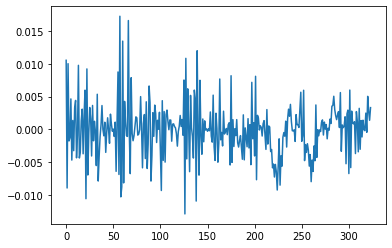

In [121]:
plt.plot(K[0,:])

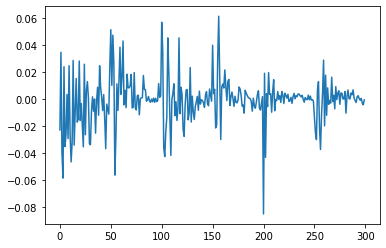

In [122]:
plt.plot(np.matmul(K,diff))

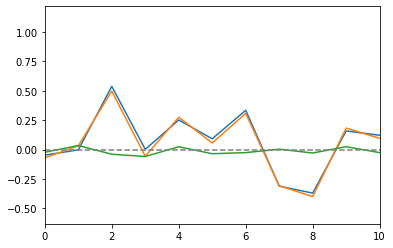

In [123]:
plt.plot(Xb_initial)
plt.plot(Xa)
plt.plot(np.matmul(K,diff))
plt.xlim(0,10)
plt.axhline(0,linestyle='--',color='gray')

## Forecast Step: 

In [124]:
LIM_Xfcast = oda.LIM_forecast(LIMd,Xa,Pa,1,adjust=False)

Adjust is False...
lag= 1


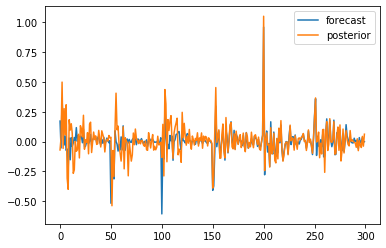

In [125]:
plt.plot(LIM_Xfcast['x_forecast'], label='forecast')
plt.plot(Xa, label = 'posterior')
plt.legend()

(0, 55)

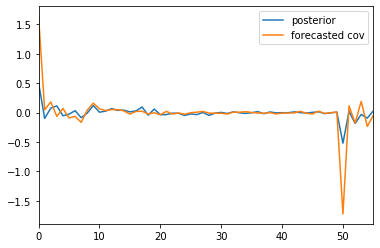

In [129]:
#plt.plot(LIM_Xfcast['cov_forecast'][0,:], label='forecast')
plt.plot(Pa[0,:], label = 'posterior')
#plt.plot(Pb[0,:], label = 'prior')
plt.plot(LIM_Xfcast['cov_forecast'][0,:], label='forecasted cov')
plt.legend()

plt.xlim(0,55)

In [106]:
LIM_Xfcast['cov_forecast'].shape

(300, 300)

In [93]:
t=1

In [99]:
Xb_initial = LIM_Xfcast['x_forecast']
Pb = LIM_Xfcast['cov_forecast']#*1e-2

Y = pseudo_obs_2d[:,t]

In [100]:
Xa, K, K_den, diff = oda.solver_KF_update(Xb_initial, Pb, Y, R_hack, H_final)

In [101]:
Pa = oda.solver_KF_cov(K,H_final,Pb)

In [102]:
Pb.min(), Pb.max()

(-0.10134772489952282, 0.1956114630467855)

In [103]:
R_hack.min(), R_hack.max()

(-3.111749205385316, 17.5771857910039)

In [104]:
mse_xb = np.nanmean(diff**2)
mse_xa = np.nanmean((Y - np.matmul(H_eof,Xa))**2)
print('Prior MSE     = '+str(mse_xb))
print('Posterior MSE = '+str(mse_xa))

Prior MSE     = 4.523977591984286
Posterior MSE = 0.7993996021462904


In [105]:
diffcov = np.dot(diff[:,np.newaxis],diff[:,np.newaxis].T)/diff.shape[0]
ratio = (np.diagonal(diffcov)/np.diagonal(K_den))
print('Median Ratio = '+str(np.median(ratio)))
print('Mean Ratio = '+str(np.mean(ratio)))

Median Ratio = 0.0004182656179529106
Mean Ratio = 0.0012521693481022712
